1- Explique, resolva e comente o exemplo 3.2 de nosso livro texto (página 113).


In [ ]:
import plotly.graph_objects as go


L = 5  

x, y, z = [], [], []
for i in range(-L, L+1):
    for j in range(-L, L+1):
        for k in range(-L, L+1):
            x.append(i)
            y.append(j)
            z.append(k)

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=4,
        color='skyblue',
        opacity=0.8,
    )
)])

fig.update_layout(
    title='Rede Cúbica Simples - Visualização 3D Interativa',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


O exemplo fornecido apresenta um código que tem como objetivo apresentar a estrutura de átomos de uma forma tridimensional. Ele utiliza de três loops aninhados para gerar todos os pontos (i,j,k) de uma rede cúbica simples 3D. O código foi readaptado para apresentar o plot acima, utilizei de pesquisa para reformular o código e conseguir o plot apresentado. Foi utilizada a biblioteca plotly.graph_objects para a geração do gráfico em 3D. O exemplo acima pode ser associado à uma estrutura cristalina, conceito utilizado em estrutura de materiais, voltado para a engenharia ou ciência dos materiais, por exemplo.

Ao passar o mouse sobre um ponto, o gráfico exibe uma caixa de informação que mostra os valores exatos das coordenadas 
(x,y,z) daquele ponto.

Isso permite que você identifique a posição de qualquer átomo na rede.

2- Explique, resolva e comente o exemplo 3.1 de nosso livro texto (página 108).

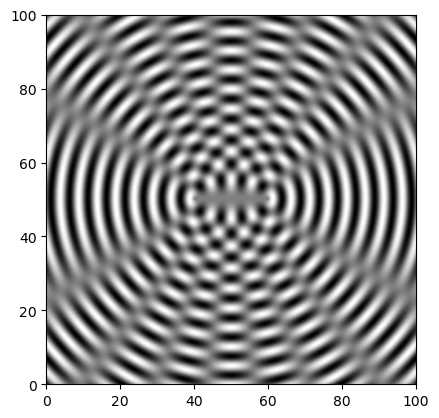

In [16]:
from math import sqrt, sin, pi
from numpy import empty
from pylab import imshow, gray, show

wavelength = 5.0
k = 2 * pi / wavelength
xi0 = 1.0
separation = 20.0  # Separação dos centros em cm
side = 100.0       # Lado do quadrado em cm
points = 500       # Número de pontos da grade em cada lado
spacing = side / points  # Espaçamento dos pontos em cm

# Calcula as posições dos centros dos círculos
x1 = side / 2 + separation / 2
y1 = side / 2
x2 = side / 2 - separation / 2
y2 = side / 2

# Cria um array para armazenar as alturas
xi = empty([points, points], float)

# Calcula os valores no array
for i in range(points):
    y = spacing * i
    for j in range(points):
        x = spacing * j
        r1 = sqrt((x - x1)**2 + (y - y1)**2)
        r2 = sqrt((x - x2)**2 + (y - y2)**2)
        xi[i, j] = xi0 * sin(k * r1) + xi0 * sin(k * r2)

# Cria o gráfico
imshow(xi, origin="lower", extent=[0, side, 0, side])
gray()
show()



Ao jogar duas pedrinhas em um lago, uma em cada lugar diferente. Cada pedrinha faz ondas que se espalham em círculos, subindo e descendo a água enquanto avançam. A altura da água em qualquer ponto depende de como essas ondas chegam, se a onda de uma pedrinha estiver subindo e a da outra também, elas se somam e a água sobe mais, se uma está subindo e a outra descendo, elas podem se cancelar e a água ficar mais baixa. Isso é o que chamamos de interferência.

No exemplo, as ondas têm um tamanho fixo (o comprimento de onda) e uma altura (a amplitude), e as pedrinhas ficam separadas por 20 cm. É calculado, a altura da água numa área grande (1 metro quadrado), dividindo essa área em uma grade bem fina, como se fosse um tabuleiro com muitos pontos. Para cada ponto desse tabuleiro, calculamos a distância até cada pedrinha e usamos uma fórmula que diz a altura da onda nesse ponto, baseada nessa distância.

Depois, somamos as alturas das duas ondas para saber qual é a altura total da água. Fazendo isso para todos os pontos, conseguimos ver no final um desenho que mostra onde as ondas se juntam e formam picos mais altos ou se anulam e a água fica mais calma. Esse desenho mostra as formas que surgem quando duas ondas se encontram e interferem uma com a outra.

In [ ]:
import pandas as pd

df = pd.read_csv('mental_health_data.csv', sep=',', quotechar='"')

# Visualizar as primeiras linhas
df.head()


,"REF_DATE,""GEO"",""DGUID"",""Age group"",""Gender"",""Indicators"",""Characteristics"",""UOM"",""UOM_ID"",""SCALAR_FACTOR"",""SCALAR_ID"",""VECTOR"",""COORDINATE"",""VALUE"",""STATUS"",""SYMBOL"",""TERMINATED"",""DECIMALS"""
0,"2002,""Canada"",""2021A000011124"",""Total, 15 year..."
1,"2002,""Canada"",""2021A000011124"",""Total, 15 year..."
2,"2002,""Canada"",""2021A000011124"",""Total, 15 year..."
3,"2002,""Canada"",""2021A000011124"",""Total, 15 year..."
4,"2002,""Canada"",""2021A000011124"",""Total, 15 year..."
